# Code to build and train cnn for binary image classification loading images in batches from the dataset on the fly, which makes this code suitable for large datasets that would not fit into memory all at once.

### Importing the required modules

In [1]:
import glob
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras import backend as K
K.set_image_dim_ordering('tf')
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Input, Lambda, AveragePooling1D
import keras.backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam
from keras.preprocessing.image import ImageDataGenerator

import cv2 as cv
import pandas as pd
import numpy as np
import os
from tqdm import tqdm


Using TensorFlow backend.


In [2]:
img_rows=128
img_cols=128
num_channel=1
num_epoch=10

In [3]:
def minmax(img):
    
    buf=img.flatten()
    
    if buf.min()!=buf.max() and buf.max()!=0: norm=((buf-buf.min())/(buf.max()-buf.min()))
    else: norm=buf/255
    
    return norm.reshape(128,128,1).astype('float32')



### Building the model

### Starting with a simple LeNet architecture (4 Conv layers + 1 Fully connected + 1 sigmoid)

In [4]:
model = Sequential()

model.add(Conv2D(32, (3,3),padding="same",input_shape=(128,128,1)))#input_shape
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(64, 3, 3))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  


#### using adam optimizer with binary_crossentropy as loss function

In [5]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 64)        18496     
__________

### adding call backs usually we would want to creat a train_validation split and use validation loss to monitor. Also we can use define our own functions and use that as validation as well.

In [6]:
from keras import callbacks

filename='model_train.csv'
csv_log=callbacks.CSVLogger(filename, separator=',', append=False)
filepath="save/Best-weights-my_model-{epoch:03d}-{loss:.4f}-{acc:.4f}.hdf5"



checkpoint = callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=False, mode='auto',period=1)

callbacks_list = [csv_log,checkpoint]


datagen2=ImageDataGenerator(preprocessing_function=minmax) # Here we pass our own preprocessing functions
hist=model.fit_generator(datagen2.flow_from_directory('train_data',target_size=(128,128),color_mode='grayscale',batch_size=32,
                                                      class_mode='binary'),shuffle=True,steps_per_epoch=243*2,epochs=num_epoch,
                                                     verbose=1,callbacks=callbacks_list)

Found 15492 images belonging to 2 classes.
Epoch 1/10
486/486 [==============================] - 253s 521ms/step - loss: 0.6365 - acc: 0.6217
Epoch 2/10
486/486 [==============================] - 253s 521ms/step - loss: 0.4221 - acc: 0.8182
Epoch 3/10
486/486 [==============================] - 253s 520ms/step - loss: 0.2820 - acc: 0.8829
Epoch 4/10
486/486 [==============================] - 253s 521ms/step - loss: 0.1758 - acc: 0.9333
Epoch 5/10
486/486 [==============================] - 253s 520ms/step - loss: 0.1207 - acc: 0.9556
Epoch 6/10
486/486 [==============================] - 253s 521ms/step - loss: 0.0856 - acc: 0.9709
Epoch 7/10
486/486 [==============================] - 253s 521ms/step - loss: 0.0675 - acc: 0.9770
Epoch 8/10
486/486 [==============================] - 252s 519ms/step - loss: 0.0577 - acc: 0.9802
Epoch 9/10
486/486 [==============================] - 254s 523ms/step - loss: 0.0598 - acc: 0.9803
Epoch 10/10
486/486 [==============================] - 253s 521ms/

### Plotting and visualization

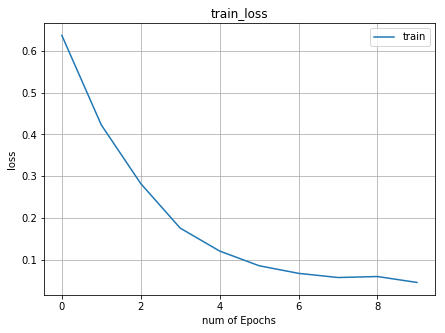

In [7]:
train_loss=hist.history['loss']

train_acc=hist.history['acc']

xc=range(num_epoch)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)

plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss')
plt.grid(True)
plt.legend(['train'])
plt.style.use(['classic'])


plt.show()

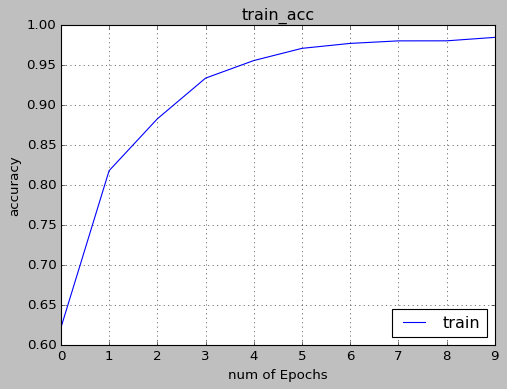

In [8]:
plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)

plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc')
plt.grid(True)
plt.legend(['train'],loc=4)

plt.style.use(['classic'])


plt.show()